# Minimal crack surfaces

$\newcommand{\Gc}{G_\text{c}}
\newcommand{\Gceff}{G_\text{c}^\text{eff}}
\newcommand{\be}{\boldsymbol{e}}
\newcommand{\bn}{\boldsymbol{n}}
\newcommand{\bx}{\boldsymbol{x}}
\newcommand{\btau}{\boldsymbol{\tau}}
\newcommand{\dOm}{\text{d}\Omega}$


In this demo, we consider the problem of computing the effective crack resistance of a heterogeneous medium with locally varying fracture energy $\Gc(\bx)$. 


<p align="center">
<img src="minimal_crack_surfaces.gif" width=400>
</p>


## A min-cut problem

We consider $\Omega$ to be some representative volume element (RVE) of the heterogeneous material. In [[BRA96]](#References), a periodic homogenization result regarding the variational approach to fracture [[FRA98]](#References) has been established. In particular, the effective fracture energy $\Gceff(\bn)$ associated with a crack of mean normal $\bn$ was explicitly characterized from the computation of minimal surfaces inside $\Omega$, weighted by the local fracture energy $\Gc(\bx)$. [[SCH20]](#References) proposed a convex optimization formulation inspired by min-cut/max-flow problems in a periodic setting. More precisely, given a prescribed crack plane normal $\bn$, they consider the following variational problem:
\begin{equation}
\Gceff(\bn) = \inf_{\phi \in V} \dfrac{1}{|\Omega|}\int_\Omega \Gc(\bx)\|\nabla \phi + \bn\|_2 \dOm 
\end{equation}
where $V$ denotes the space of smooth scalar functions which are periodic over $\Omega$. This min-cut problem is known to have minimizers corresponding to $\Gc$-weighted periodic minimal surfaces.



The min-cut problem is implemented in the `solver.MinCut` class and uses an `L2Norm` objective function and the `SumExpr` formal expression to include the constant term $\bn$ in the objective.

```python
class MinCut:
    """MinCut problem of minimal crack surface."""

    def __init__(self, mesh, Gc, n, verbose=True):
        self.mesh = mesh
        self.Gc = Gc
        self.n = n
        self.verbose = verbose

        vertices = np.array([[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]])
        self.V = FunctionSpace(
            self.mesh, "CG", 1, constrained_domain=PeriodicBoundary(vertices, 1e-10)
        )

    def set_problem(self):
        self.prob = MosekProblem("Minimal crack surface")

        self.phi = self.prob.add_var(self.V)

        cost = L2Norm(SumExpr(grad(self.phi), self.n), k=self.Gc)
        self.prob.add_convex_term(cost)
        self.xi_name = cost.additional_variables[0].name()

    def solve(self):
        self.set_problem()
        self.prob.parameters["log_level"] = int(self.verbose)
        self.prob.optimize()
        self.xi = self.prob.get_var(self.xi_name).sub(0, True)
        self.xi.rename("Crack density", "")
```

## The dual max-flow problem

In order to assess the influence of spatial discretization on the computed fracture energy, we also solve the corresponding dual max-flow problem:

$$
\begin{array}{rll}\displaystyle{\Gceff(\bn) = \sup_{\btau \in W}} & \displaystyle{\dfrac{1}{|\Omega|}\int_\Omega \btau\cdot\bn \dOm}  & \\
\text{s.t.} & \operatorname{div} \btau(\bx) = 0 & \forall \bx\in\Omega \\
& \|\btau(\bx)\|_2 \leq \Gc(\bx)  &
\end{array}
$$

where $W$ is a function space of smooth periodic vector fields with normal component continuity. Upon proper discretization of the above problem e.g. using a first-order Raviart-Thomas function space (see the [Cheeger set example](../Cheeger_sets/Cheeger_dual.rst)), the obtained optimal value can be shown to provide a lower bound to the exact effective crack energy $\Gceff(\bn)$. Solving both min-cut and max-flow problems with proper discretization will therefore furnish a bracketing of the exact value.

The max-flow problem is implemented in the `solver.MaxFlow` class and uses an `L2Ball` constraint and the `SumExpr` formal expression to include the constant term $\bn$ in the objective.

```python
class MaxFlow:
    """MaxFlow problem of minimal crack surface."""

    def __init__(self, mesh, Gc, n, verbose=True):
        self.mesh = mesh
        self.Gc = Gc
        self.n = n
        self.verbose = verbose

        vertices = np.array([[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]])
        self.V = FunctionSpace(self.mesh, "DG", 0)
        self.V0v = FunctionSpace(
            self.mesh, "RT", 1, constrained_domain=PeriodicBoundary(vertices, 1e-10)
        )

    def set_problem(self):
        self.prob = MosekProblem("Minimal crack surface")

        self.v = self.prob.add_var(self.V0v)

        def constraint(u):
            """Equilibrium constraint."""
            return inner(u, div(self.v)) * dx

        self.prob.add_eq_constraint(self.V, A=constraint, name="phi")

        # We add the L2-Ball constraint ||v||_2 <= Gc
        F = L2Ball(self.v, k=self.Gc, quadrature_scheme="vertex")
        self.prob.add_convex_term(F)

        self.prob.add_obj_func(dot(self.v, self.n) * dx)

    def solve(self):
        self.set_problem()
        self.prob.parameters["log_level"] = int(self.verbose)
        self.prob.optimize(sense="max")
        VCG1 = FunctionSpace(self.mesh, "CG", 1)
        self.phi = project(self.prob.get_lagrange_multiplier("phi"), VCG1)

        def norm(x):
            return sqrt(dot(x, x))

        self.xi = project(norm(self.n + grad(self.phi)), self.V)
```

## Illustrating example

<p align="center">
<img src="minimal_crack_surfaces.svg" width=600>
</p>

We consider a simple microstructure consisting of a periodic square unit cell and circular inclusions of radius $R \leq R_0=1/(2\sqrt{2})$ located at the cell center and at its four corners, see Figure. $R_0$ denotes the maximum radius corresponding to each inclusion touching each other. The inclusion material possesses a fracture energy which is much larger than that of the matrix. Inclusions can thus be considered as infinitely resistant so that minimal crack surfaces will always pass through the matrix material only with fracture energy $\Gc$.

Let us first consider the effective fracture energy for cracks of normal $\be_x$ (or $\be_y$ for symmetry reasons). For small enough inclusions i.e. $R\leq 1/4$, there always exists a straight crack plane passing inside the matrix (a). Thus, $\Gceff(\be_x)=\Gc$ for any $R\leq 1/4$. For larger $R$ up to $R=R_0$, the optimal path consists of a part of the circular inclusion border connected by a straight line between each inclusions. In the limit case $R=R_0$, the straight line vanishes and the total path length is $\pi R_0$ (b). As a result, the effective fracture energy is $\Gceff(\be_x)=\dfrac{\pi}{2\sqrt{2}}\Gc \approx 1.11\Gc$.

Regarding crack planes oriented at $\pm 45^\circ$, for any $R$ up to $R_0$ there exists a $\pm 45^\circ$ degree line connecting the mid-point of the square domains as indicated in the figure. As a result, the corresponding fracture energy will always be $\Gceff = \Gc$ for this orientation.

Below we generate the corresponding microstructure, note that we affect a value of $G_c = 20$ for the inclusions but this value does not impact the results as long as it is sufficiently large.

Generating microstructure...


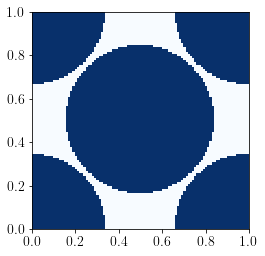

In [1]:
from dolfin import (
    Constant,
    Function,
    FunctionSpace,
    project,
    XDMFFile,
    plot,
)
from ufl import cos, sin, pi
from periodic_microstructure import generate_microstructure
from solver import MinCut, MaxFlow
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(15012017)

problem_type = "array"  # or "random"

if problem_type == "array":
    N = 100
    radius = 0.34
    centers = np.array([[N / 2, N / 2], [0, 0]])
    radii = np.array([radius * N] * 2)
    file_name = f"array_radius_{radius}"
elif problem_type == "random":
    N = 250
    Nincl = 80
    radius = 0.05
    centers = N * np.random.rand(Nincl, 2)
    radii = radius * N * np.random.normal(1, 0.4, size=(Nincl,))
    file_name = "random"

mesh, y = generate_microstructure(centers, radii, (N, N))

V0 = FunctionSpace(mesh, "DG", 0)

Gc = Function(V0, name="Gc")
Gc1 = 1.0
Gc2 = 20.0
Gc.assign(project((1 - y) * Gc1 + y * Gc2, V0))

plot(Gc, cmap="Blues")
plt.show()

We then compute the optimal crack surface for various crack plane orientation $\theta$. We perform both a min-cut and max-flow computation for each angle to obtain an exact bracketing of the effective crack surface energy $\Gceff$.

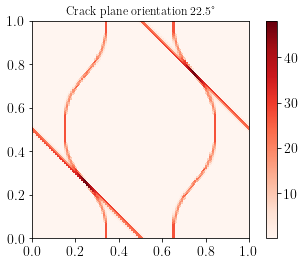

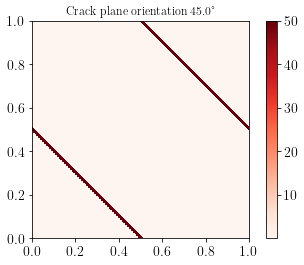

In [2]:
output_file = XDMFFile(f"{file_name}.xdmf")
output_file.parameters["functions_share_mesh"] = True
output_file.parameters["flush_output"] = True

theta_list = np.linspace(0, 45, 3)
results = np.zeros((len(theta_list), 3))
results[:, 0] = theta_list
for (i, theta) in enumerate(theta_list):
    n = Constant((cos(pi * theta / 180), sin(pi * theta / 180)))

    min_cut = MinCut(mesh, Gc, n, verbose=False)
    min_cut.solve()

    output_file.write(min_cut.xi, theta)
    output_file.write(Gc, theta)

    results[i, 1] = min_cut.prob.pobj

    plt.figure()
    pl = plot(min_cut.xi, cmap="Reds")
    plt.colorbar(pl)
    plt.title(f"Crack plane orientation {theta}°")
    plt.show()

    max_flow = MaxFlow(mesh, Gc, n, verbose=False)
    max_flow.solve()
    results[i, 2] = max_flow.prob.pobj

For each angle, we can compare the min-cut estimate with the max-flow estimate:

In [6]:
for data in results:
    print(f"Angle {data[0]:4.1f}°:")
    print(f"      max-flow = {data[2]:.3f} <= Gceff <= min-cut = {data[1]:.3f}")

Angle  0.0°:
      max-flow = 1.088 <= Gceff <= min-cut = 1.114
Angle 22.5°:
      max-flow = 1.129 <= Gceff <= min-cut = 1.144
Angle 45.0°:
      max-flow = 1.000 <= Gceff <= min-cut = 1.000


## References

[BRA96] Braides, A., Defranceschi, A., & Vitali, E. (1996). Homogenization of free discontinuity problems. Archive for rational mechanics and analysis, 135(4), 297-356.

[FRA98] Francfort, G. A., & Marigo, J. J. (1998). Revisiting brittle fracture as an energy minimization problem. Journal of the Mechanics and Physics of Solids, 46(8), 1319-1342.

[SCH20] Schneider, M. (2020). An FFT‐based method for computing weighted minimal surfaces in microstructures with applications to the computational homogenization of brittle fracture. International Journal for Numerical Methods in Engineering, 121(7), 1367-1387.

[ERN21] Ernesti, F., & Schneider, M. (2021). A fast Fourier transform based method for computing the effective crack energy of a heterogeneous material on a combinatorially consistent grid. International Journal for Numerical Methods in Engineering, 122(21), 6283-6307.